In [3]:
import tensorflow as tf
import numpy as np
import cv2 as cv
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Generate Data

In [ ]:
#!gdown --folder https://drive.google.com/drive/folders/1JpSyla7p1868UjaHWZcAdcQc4LCp6IGh?usp=share_link

In [6]:
metadata_path = "./data/mimic_iv_csv/"
mimiciv = pd.read_csv(os.path.join(metadata_path,'img_gapyear.csv')) # contain survival year data
patients = pd.read_csv(os.path.join(metadata_path,'patients.csv'))
unique_subject = list(patients['subject_id'].unique())
agee = pd.read_csv(os.path.join(metadata_path,'Age.csv'))
admission = pd.read_csv(os.path.join(metadata_path,'admissions.csv'))
admission['race'] = admission['race'].replace({'ASIAN - ASIAN INDIAN': 'ASIAN', 'ASIAN - CHINESE': 'ASIAN', 
                                                           'ASIAN - KOREAN': 'ASIAN', 'ASIAN - SOUTH EAST ASIAN': 'ASIAN', 'BLACK/AFRICAN AMERICAN': 'BLACK/AFRICAN',
                                                           'BLACK/AFRICAN AMERICAN ': 'BLACK/AFRICAN', 'BLACK/CAPE VERDEAN': 'BLACK/AFRICAN', 'BLACK/CARIBBEAN ISLAND': 'BLACK/AFRICAN', 
                                                           'HISPANIC OR LATINO': 'HISPANIC/LATINO', 'HISPANIC/LATINO - COLUMBIAN': 'HISPANIC/LATINO','HISPANIC/LATINO - CUBAN':'HISPANIC/LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN':'HISPANIC/LATINO', 
                                                           'HISPANIC/LATINO - GUATEMALAN': 'HISPANIC/LATINO', 'HISPANIC/LATINO - SALVADORAN': 'HISPANIC/LATINO',
                                                           'HISPANIC/LATINO - DOMINICAN':'HISPANIC/LATINO', 'HISPANIC/LATINO - HONDURAN':'HISPANIC/LATINO', 'HISPANIC/LATINO - MEXICAN':'HISPANIC/LATINO', 'HISPANIC/LATINO - PUERTO RICAN': 'HISPANIC/LATINO',
                                                           'MULTIPLE RACE/ETHNICITY':'OTHER', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER':'OTHER', 'PORTUGUESE': 'OTHER', 'SOUTH AMERICAN':'HISPANIC/LATINO', 
                                                          'WHITE - BRAZILIAN':'WHITE', 'WHITE - EASTERN EUROPEAN':'WHITE', 'WHITE - OTHER EUROPEAN':'WHITE', 'WHITE - RUSSIAN': 'WHITE',
                                                          'PATIENT DECLINED TO ANSWER':'UNKNOWN', 'UNABLE TO OBTAIN': 'UNKNOWN'})

In [17]:
imgs = [] # all images in npy array
y = []  # survival_year
subject_idd = []
study_idd=[]
race=[]
gender=[]
age=[]
insurance=[]
set_belong = [] # 'train', 'test', 'val'

def tf_records_to_array(disease:list):   
    '''
    disease: a list of image labels, 
    Get images of certain label ('No Finding', 'Edema', ...)
    Read bytes data from tf_records into images and metadata (sex,race,age,insurance)
    return 4D npy array of images, and a dataframe of metadata associated with each image
    '''
    assert len(disease) == 1 or len(disease) == 2 # only support up to 2 classes

    for dataset in tqdm(['train', 'test', 'val']):
        filename = f'data/tf_records/mimic_{dataset}.tfrecords'
        raw_dataset = tf.data.TFRecordDataset(filename)

        for raw_record in raw_dataset:

            example = tf.train.Example()
            example.ParseFromString(raw_record.numpy())

            subject_id = example.features.feature['subject_id'].int64_list.value[0]
            study_id = example.features.feature['study_id'].int64_list.value[0]
            
            # select CXRs
            if len(disease) == 1: # 'No Finding', 'Edema'
                img_found = example.features.feature[disease[0]].float_list.value[0] == 1
            elif len(disease) == 2:
                img_found = example.features.feature[disease[0]].float_list.value[0] == 1 or example.features.feature[disease[1]].float_list.value[0] == 1
            else:
                print('ERROR IN DISEASE SPECIFICATION')
                return -1
            if img_found:
                nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
                img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)
                #convert to (256,256,3) dimension to use imagenet pretrained weights
                gary2rgb = cv.cvtColor(img_np,cv.COLOR_GRAY2RGB) 
                imgs.append(gary2rgb)
            
                mimiciv_sub = mimiciv.loc[mimiciv['subject_id'] == subject_id]
                if mimiciv_sub.empty:
                    y.append(-1)
                else:
                    y.append(mimiciv_sub.loc[mimiciv_sub['study_id'] == study_id,'gap_year'].iloc[0])
            
                subject_idd.append(subject_id)
                study_idd.append(study_id)
                
                admission_sub = admission.loc[admission['subject_id'] == subject_id]
                patients_sub = patients.loc[patients['subject_id'] == subject_id]
                age_sub = agee.loc[agee['subject_id'] == subject_id]
                
                #getting the 'race', 'insurance', 'gender' and 'age' features(fill np.nan with N/a)
                if admission_sub.empty:
                    race.append(np.nan)
                    insurance.append(np.nan)
                else:
                    race.append(admission_sub.loc[admission_sub['subject_id'] == subject_id,'race'].iloc[0])
                    insurance.append(admission_sub.loc[admission_sub['subject_id'] == subject_id,'insurance'].iloc[0])
            
                if patients_sub.empty:
                    gender.append(np.nan)
                else:
                    gender.append(patients_sub.loc[patients_sub['subject_id'] == subject_id,'gender'].iloc[0])
            
                if age_sub.empty:
                    age.append(np.nan)
                else:
                    age.append(age_sub.loc[age_sub['subject_id'] == subject_id,'age'].iloc[0])
                set_belong.append(dataset)
    
                assert len(imgs) == len(subject_idd) == len(study_idd) == len(set_belong) == len(age) == len(gender) == len(race) == len(insurance)
    
    df_info = pd.DataFrame({'img_index': list(range(len(subject_idd))),
                            'subject_id':subject_idd, 
                            'study_id': study_idd,
                            'dataset': set_belong,
                            'race': race,
                            'gender': gender,
                            'age': age,
                            'insurance': insurance,
                            'survival_year': y}) 

    return imgs, df_info #y, subject_idd, study_idd, race, gender, age, insurance, set_belong

In [ ]:
# 1. pulmonary 'Edema' -> 24704 images
# 2. combine 'Pneumonia' + 'Consolidation' -> 21692 images
# 3. 'No Finding' -> 81566 images

In [21]:
disease_l = ['No Finding'] #['Pneumonia' , 'Consolidation'] #['Edema'], ['No Finding']
imgs, df_info = tf_records_to_array(disease_l)

  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_11946/3269302721.py:41: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
100%|██████████| 3/3 [03:40<00:00, 73.35s/it] 


In [22]:
df_info

,img_index,subject_id,study_id,dataset,race,gender,age,insurance,survival_year
0,0,15529160,51401638,train,ASIAN,M,56.0,Medicaid,-1.00
1,1,15529160,51401638,train,ASIAN,M,56.0,Medicaid,-1.00
2,2,13091743,53950471,train,ASIAN,M,85.0,Medicare,0.50
3,3,17556194,50043089,train,ASIAN,F,73.0,Other,0.96
4,4,17556194,50878495,train,ASIAN,F,73.0,Other,1.66
...,...,...,...,...,...,...,...,...,...
81561,81561,19948788,54253734,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00
81562,81562,19948788,56226482,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00
81563,81563,19948788,58554921,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00
81564,81564,19948788,58554921,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00


In [23]:
# df_info.to_csv('data/No_finding/df_No_finding_1121.csv', index = False)
# np.save('data/No_finding/X_No_finding.npy', imgs)

In [20]:
# df_info.to_csv('data/img_array/df_Pneumonia_Consolidation_1121.csv', index = False)
# np.save('data/img_array/X_Pneumonia_Consolidation.npy', imgs)

In [33]:
dataset = 'train'
filename = f'data/mimic_{dataset}.tfrecords'
raw_dataset = tf.data.TFRecordDataset(filename)

for raw_record in raw_dataset:

    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    subject_id = example.features.feature['subject_id'].int64_list.value[0]
    study_id = example.features.feature['study_id'].int64_list.value[0]
    
    #only get the 'No Finding' CXRs
    if example.features.feature['No Finding'].float_list.value[0] == 1:
        nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
        img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)
        gary2rgb = cv.cvtColor(img_np,cv.COLOR_GRAY2RGB) #convert to (256,256,3) dimension
        
        break

C:\Users\antho\AppData\Local\Temp\ipykernel_7448\2895462203.py:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)


In [35]:
print(nparr.shape, img_np.shape, gary2rgb.shape)

(9444,) (256, 256) (256, 256, 3)


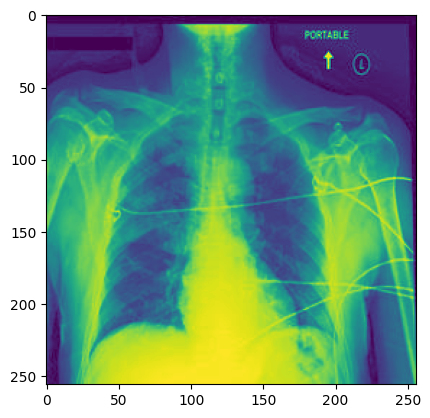

In [37]:
plt.imshow(img_np)

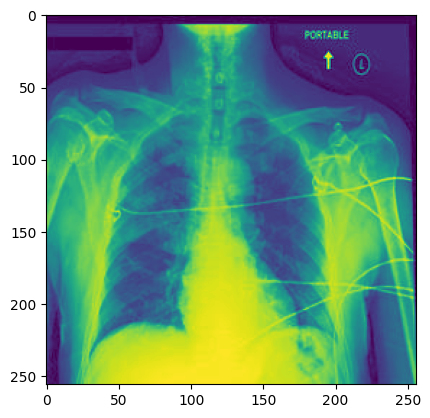

In [47]:
plt.imshow(gary2rgb[:,:,2])

# Load Data

In [4]:
df_info = pd.read_csv('data\mimic_iv_csv\df_info_1116.csv')
df_info

,img_index,subject_id,study_id,dataset,race,gender,age,insurance,survival_year
0,0,11135741,52912807,train,ASIAN,M,53.0,Other,-1.00
1,1,13091743,51959936,train,ASIAN,M,85.0,Medicare,0.85
2,2,13091743,53279329,train,ASIAN,M,85.0,Medicare,0.51
3,3,13091743,53691912,train,ASIAN,M,85.0,Medicare,0.20
4,4,13091743,56124505,train,ASIAN,M,85.0,Medicare,0.68
...,...,...,...,...,...,...,...,...,...
59869,59869,19948788,54253734,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00
59870,59870,19948788,56226482,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00
59871,59871,19948788,58554921,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00
59872,59872,19948788,58554921,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00


In [2]:
df_features = pd.read_csv('data\mimic_iv_csv/features_data_1117.csv')
df_features

,subject_id,study_id,set,gap_year,race,gender,age,insurance,dod,study_date,anchor_year
0,11135741,52912807,train,-1.00,ASIAN - CHINESE,M,53.0,Other,NaN,21430206,2143.0
1,13091743,51959936,train,0.85,ASIAN - CHINESE,M,85.0,Medicare,2159/1/26,21580323,2158.0
2,13091743,53279329,train,0.51,ASIAN - CHINESE,M,85.0,Medicare,2159/1/26,21580723,2158.0
3,13091743,53691912,train,0.20,ASIAN - CHINESE,M,85.0,Medicare,2159/1/26,21581115,2158.0
4,13091743,56124505,train,0.68,ASIAN - CHINESE,M,85.0,Medicare,2159/1/26,21580523,2158.0
...,...,...,...,...,...,...,...,...,...,...,...
59869,19992875,55841702,train,-1.00,WHITE,M,39.0,Medicare,NaN,21620214,2160.0
59870,19992875,59582745,train,-1.00,WHITE,M,38.0,Medicare,NaN,21610913,2160.0
59871,19998350,51819111,train,-1.00,BLACK/AFRICAN AMERICAN,M,53.0,Medicare,NaN,21280221,2127.0
59872,19998350,51819111,train,-1.00,BLACK/AFRICAN AMERICAN,M,53.0,Medicare,NaN,21280221,2127.0


In [15]:
df_features.groupby('set').nunique()['study_id']

set
test     10469
train    32018
val      10644
Name: study_id, dtype: int64

In [16]:
df_info['dataset'].value_counts()

train    35307
test     18362
val       6205
Name: dataset, dtype: int64

In [17]:
df_features['set'].value_counts()

train    36152
val      11909
test     11813
Name: set, dtype: int64

In [3]:
df_meta = pd.read_csv('data\mimic_iv_csv\df_race_3class_1117.csv')
df_meta

,img_index,subject_id,study_id,dataset,race,gender,age,insurance,survival_year
0,0,11135741,52912807,train,ASIAN,M,53.0,Other,-1.00
1,1,13091743,51959936,train,ASIAN,M,85.0,Medicare,0.85
2,2,13091743,53279329,train,ASIAN,M,85.0,Medicare,0.51
3,3,13091743,53691912,train,ASIAN,M,85.0,Medicare,0.20
4,4,13091743,56124505,train,ASIAN,M,85.0,Medicare,0.68
...,...,...,...,...,...,...,...,...,...
58983,59869,19948788,54253734,test,BLACK,F,44.0,Medicaid,-1.00
58984,59870,19948788,56226482,test,BLACK,F,44.0,Medicaid,-1.00
58985,59871,19948788,58554921,test,BLACK,F,44.0,Medicaid,-1.00
58986,59872,19948788,58554921,test,BLACK,F,44.0,Medicaid,-1.00


In [25]:
# change the dataset allocation based on new feature.csv from Aubrey
ds_l = []
for i in range(df_meta.shape[0]):
    subject = df_meta.iloc[i,1]
    true_ds = list(df_features[df_features['subject_id'] == subject]['set'].unique())
    assert len(true_ds) == 1
    true_ds = true_ds[0]
    ds_l.append(true_ds)

In [27]:
df_meta['dataset'] = ds_l

In [30]:
# df_meta.to_csv('data\mimic_iv_csv\df_race_3class_1117.csv', index=False)

In [29]:
df_meta['dataset'].value_counts(normalize=True)
# 34800, 18083, 6105 -> 35635, 11715, 11638

train    0.604106
val      0.198600
test     0.197294
Name: dataset, dtype: float64

In [40]:
df_meta.iloc[-1,4]

'BLACK'

In [2]:
# X_all = np.load('data/X_all_1116.npy')
# print(X_all.shape)

(59874, 256, 256, 3)


In [34]:
loaded = np.load('data\X_race_split_1116.npz')
X_train = loaded['train']
X_test = loaded['test']
X_val = loaded['val']

In [35]:
X_all = np.concatenate((X_train, X_test, X_val))
print(X_all.shape)

(58988, 256, 256, 3)


In [41]:
# from pathlib import Path
# class_names = ['WHITE', 'BLACK', 'ASIAN']
# DATA_DIR = Path('data/imgs_race')

# DATASETS = ['train', 'test', 'val']

# for ds in DATASETS:
#   for cls in class_names:
#     (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

# from PIL import Image
# for i in tqdm(range(X_all.shape[0])):
#     im = Image.fromarray(X_all[i])
#     ds = df_meta.iloc[i, 3]
#     cls = df_meta.iloc[i, 4]
    
#     fname = f'{DATA_DIR}/{ds}/{cls}/{i}.jpeg'
#     im.save(fname)

100%|██████████| 58988/58988 [02:00<00:00, 489.30it/s]


In [5]:
X_all[[1,2,3]].shape

(3, 256, 256, 3)

In [ ]:
df_race = df_meta

In [8]:
X_train = X_all[df_race[df_race['dataset'] == 'train']['img_index'].tolist()]

In [9]:
X_test = X_all[df_race[df_race['dataset'] == 'test']['img_index'].tolist()]

In [10]:
X_val = X_all[df_race[df_race['dataset'] == 'val']['img_index'].tolist()]

In [12]:
# np.savez('data/X_race_split_1116', train = X_train,
#                                            test = X_test,
#                                            val = X_val)

In [11]:
# np.savez_compressed('data/X_race_split_1116', train = X_train,
#                                                 test = X_test,
#                                                 val = X_val)

KeyboardInterrupt: 

In [ ]:
print(X_train.shape[0], X_test.shape[0], X_val.shape[0])

In [31]:
df_info = pd.read_csv('data\mimic_iv_csv/df_info_1116.csv')
df_info

,img_index,subject_id,study_id,dataset,race,gender,age,insurance,survival_year
0,0,11135741,52912807,train,ASIAN,M,53.0,Other,-1.00
1,1,13091743,51959936,train,ASIAN,M,85.0,Medicare,0.85
2,2,13091743,53279329,train,ASIAN,M,85.0,Medicare,0.51
3,3,13091743,53691912,train,ASIAN,M,85.0,Medicare,0.20
4,4,13091743,56124505,train,ASIAN,M,85.0,Medicare,0.68
...,...,...,...,...,...,...,...,...,...
59869,59869,19948788,54253734,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00
59870,59870,19948788,56226482,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00
59871,59871,19948788,58554921,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00
59872,59872,19948788,58554921,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00


In [53]:
df_clean = df_info.dropna()
df_clean # 59874 -> 59710 

,img_index,subject_id,study_id,dataset,race,gender,age,insurance,survival_year
0,0,11135741,52912807,train,ASIAN,M,53.0,Other,-1.00
1,1,13091743,51959936,train,ASIAN,M,85.0,Medicare,0.85
2,2,13091743,53279329,train,ASIAN,M,85.0,Medicare,0.51
3,3,13091743,53691912,train,ASIAN,M,85.0,Medicare,0.20
4,4,13091743,56124505,train,ASIAN,M,85.0,Medicare,0.68
...,...,...,...,...,...,...,...,...,...
59869,59869,19948788,54253734,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00
59870,59870,19948788,56226482,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00
59871,59871,19948788,58554921,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00
59872,59872,19948788,58554921,val,BLACK/AFRICAN,F,44.0,Medicaid,-1.00


## Race
Only select 'WHITE', 'BLACK/AFRICAN', 'ASIAN',
(drop Indian, hispanic, other, unknown)

In [27]:
df_vis = df_meta.copy(deep=True)

In [28]:
df_vis['race'].value_counts()

WHITE    42985
BLACK    13729
ASIAN     2274
Name: race, dtype: int64

(array([ 2274.,     0.,     0.,     0.,     0., 42985.,     0.,     0.,
            0., 13729.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

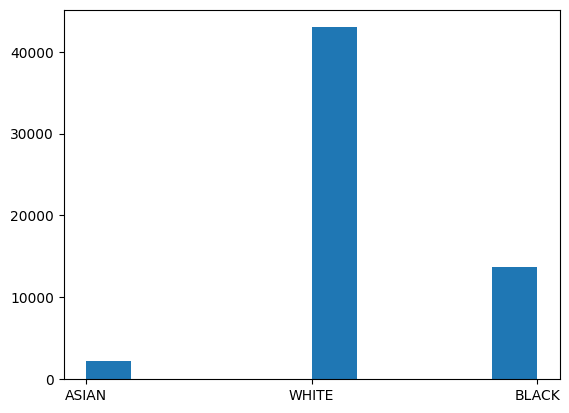

In [29]:
plt.hist(df_vis['race'].tolist())


(array([4.3775e+04, 8.0500e+03, 2.1980e+03, 1.5270e+03, 1.2900e+03,
        8.9200e+02, 6.2600e+02, 4.1400e+02, 1.8200e+02, 3.4000e+01]),
 array([-1.   , -0.011,  0.978,  1.967,  2.956,  3.945,  4.934,  5.923,
         6.912,  7.901,  8.89 ]),
 <BarContainer object of 10 artists>)

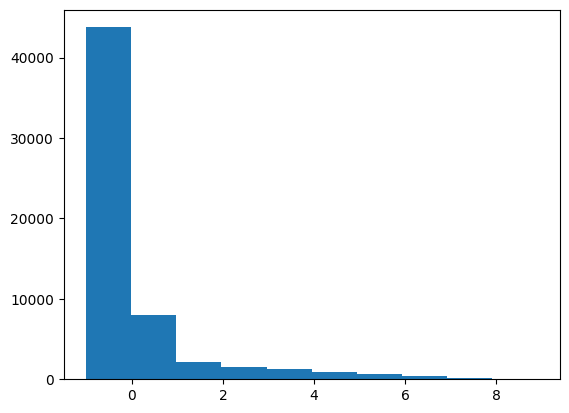

In [10]:
plt.hist(df_vis['survival_year'].tolist())

In [16]:
def show_pie_chart(df_vis):
    df_vis_plot = df_vis.copy(deep=True).reset_index(drop=True)
    bins = np.arange(0,100,5)
    #df_test_plot = X_test_raw.copy(deep=True).reset_index(drop=True)
    df_vis_plot['age_group'] = pd.cut(df_vis_plot['age'], bins=bins)
    #df_test_plot['age_group'] = pd.cut(df_test_plot['age'], bins=bins)

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(25, 7))

    df_vis_plot.groupby('gender').size().plot(kind='pie', autopct='%1.0f%%', 
                                textprops={'fontsize': 15},ax=ax1)

    df_vis_plot.groupby('race').size().plot(kind='pie', autopct='%1.0f%%', 
                                textprops={'fontsize': 10},ax=ax2)

    df_vis_plot.groupby('age_group').size().plot(kind='pie', autopct='%1.0f%%', 
                                textprops={'fontsize': 10},ax=ax3)

    ax1.set_ylabel('Per gender', size=10)
    ax2.set_ylabel('Per race', size=10)
    ax3.set_ylabel('Per age group', size=10)
    plt.tight_layout()
    plt.show()

In [14]:
df_train = df_vis[df_vis['dataset'] == 'train']
df_test = df_vis[df_vis['dataset'] == 'test']
df_val = df_vis[df_vis['dataset'] == 'val']

(array([7735., 2149., 1504., 1177.,  969.,  692.,  502.,  315.,  144.,
          26.]),
 array([0.   , 0.889, 1.778, 2.667, 3.556, 4.445, 5.334, 6.223, 7.112,
        8.001, 8.89 ]),
 <BarContainer object of 10 artists>)

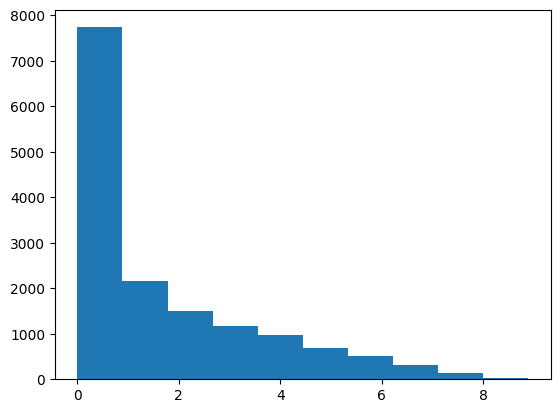

In [26]:
plt.hist(df_vis[df_vis['survival_year'] >= 0]['survival_year'])

In [30]:
df_vis['survival_year'][0]

-1.0

In [34]:
surv_l = []
for i in range(df_vis.shape[0]):
    sur_year = df_vis['survival_year'][i]
    to_add = np.nan
    if sur_year > 1:
        to_add = 0 # survive longer than 1 year
    elif sur_year < 0:
        None
    else:
        to_add = 1 # die within 1 year
    surv_l.append(to_add)
df_vis['survive'] = surv_l
df_vis

,img_index,subject_id,study_id,dataset,race,gender,age,insurance,survival_year,survive
0,0,11135741,52912807,train,ASIAN,M,53.0,Other,-1.00,NaN
1,1,13091743,51959936,train,ASIAN,M,85.0,Medicare,0.85,1.0
2,2,13091743,53279329,train,ASIAN,M,85.0,Medicare,0.51,1.0
3,3,13091743,53691912,train,ASIAN,M,85.0,Medicare,0.20,1.0
4,4,13091743,56124505,train,ASIAN,M,85.0,Medicare,0.68,1.0
...,...,...,...,...,...,...,...,...,...,...
58983,59869,19948788,54253734,test,BLACK,F,44.0,Medicaid,-1.00,NaN
58984,59870,19948788,56226482,test,BLACK,F,44.0,Medicaid,-1.00,NaN
58985,59871,19948788,58554921,test,BLACK,F,44.0,Medicaid,-1.00,NaN
58986,59872,19948788,58554921,test,BLACK,F,44.0,Medicaid,-1.00,NaN


In [36]:
df_vis['survive'].value_counts(normalize=True)

1.0    0.534148
0.0    0.465852
Name: survive, dtype: float64

In [37]:
df_dead = df_vis.dropna()
df_dead

,img_index,subject_id,study_id,dataset,race,gender,age,insurance,survival_year,survive
1,1,13091743,51959936,train,ASIAN,M,85.0,Medicare,0.85,1.0
2,2,13091743,53279329,train,ASIAN,M,85.0,Medicare,0.51,1.0
3,3,13091743,53691912,train,ASIAN,M,85.0,Medicare,0.20,1.0
4,4,13091743,56124505,train,ASIAN,M,85.0,Medicare,0.68,1.0
5,5,17556194,50284841,train,ASIAN,F,73.0,Other,1.06,0.0
...,...,...,...,...,...,...,...,...,...,...
58959,59845,19737402,52394316,train,BLACK,M,55.0,Other,0.55,1.0
58960,59846,19737402,56254040,train,BLACK,M,55.0,Other,0.56,1.0
58968,59854,19819686,52547154,val,BLACK,F,89.0,Medicare,0.01,1.0
58977,59863,19894835,55514350,test,WHITE,M,71.0,Medicare,6.15,0.0


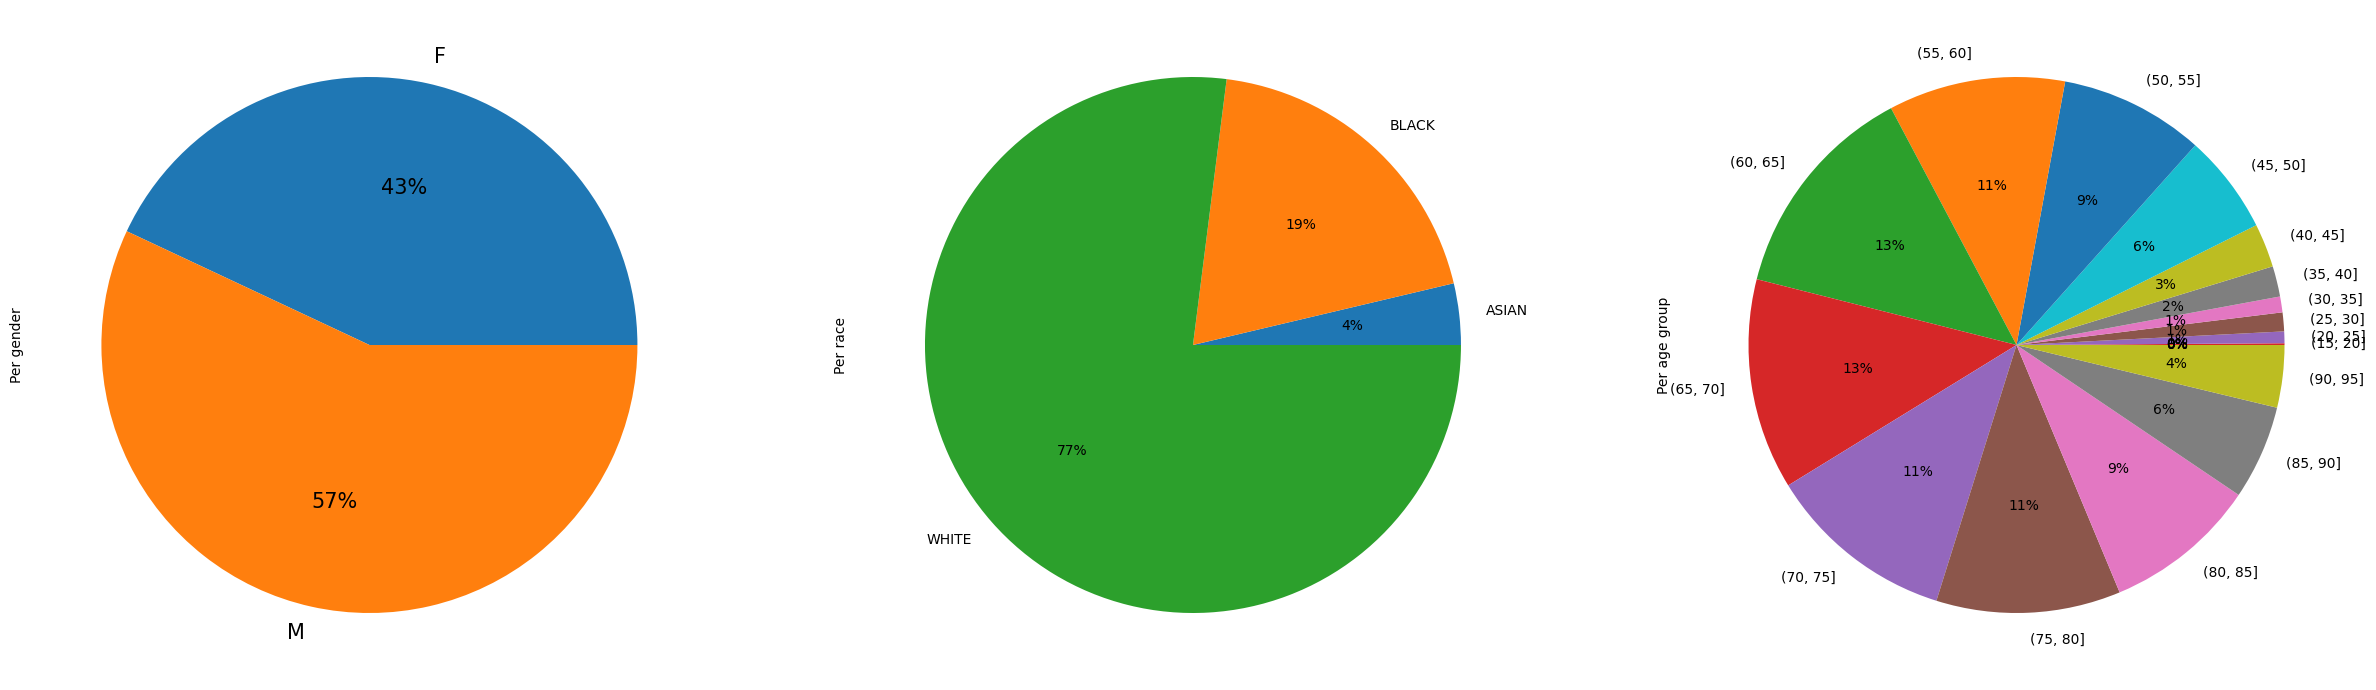

In [38]:
show_pie_chart(df_dead)

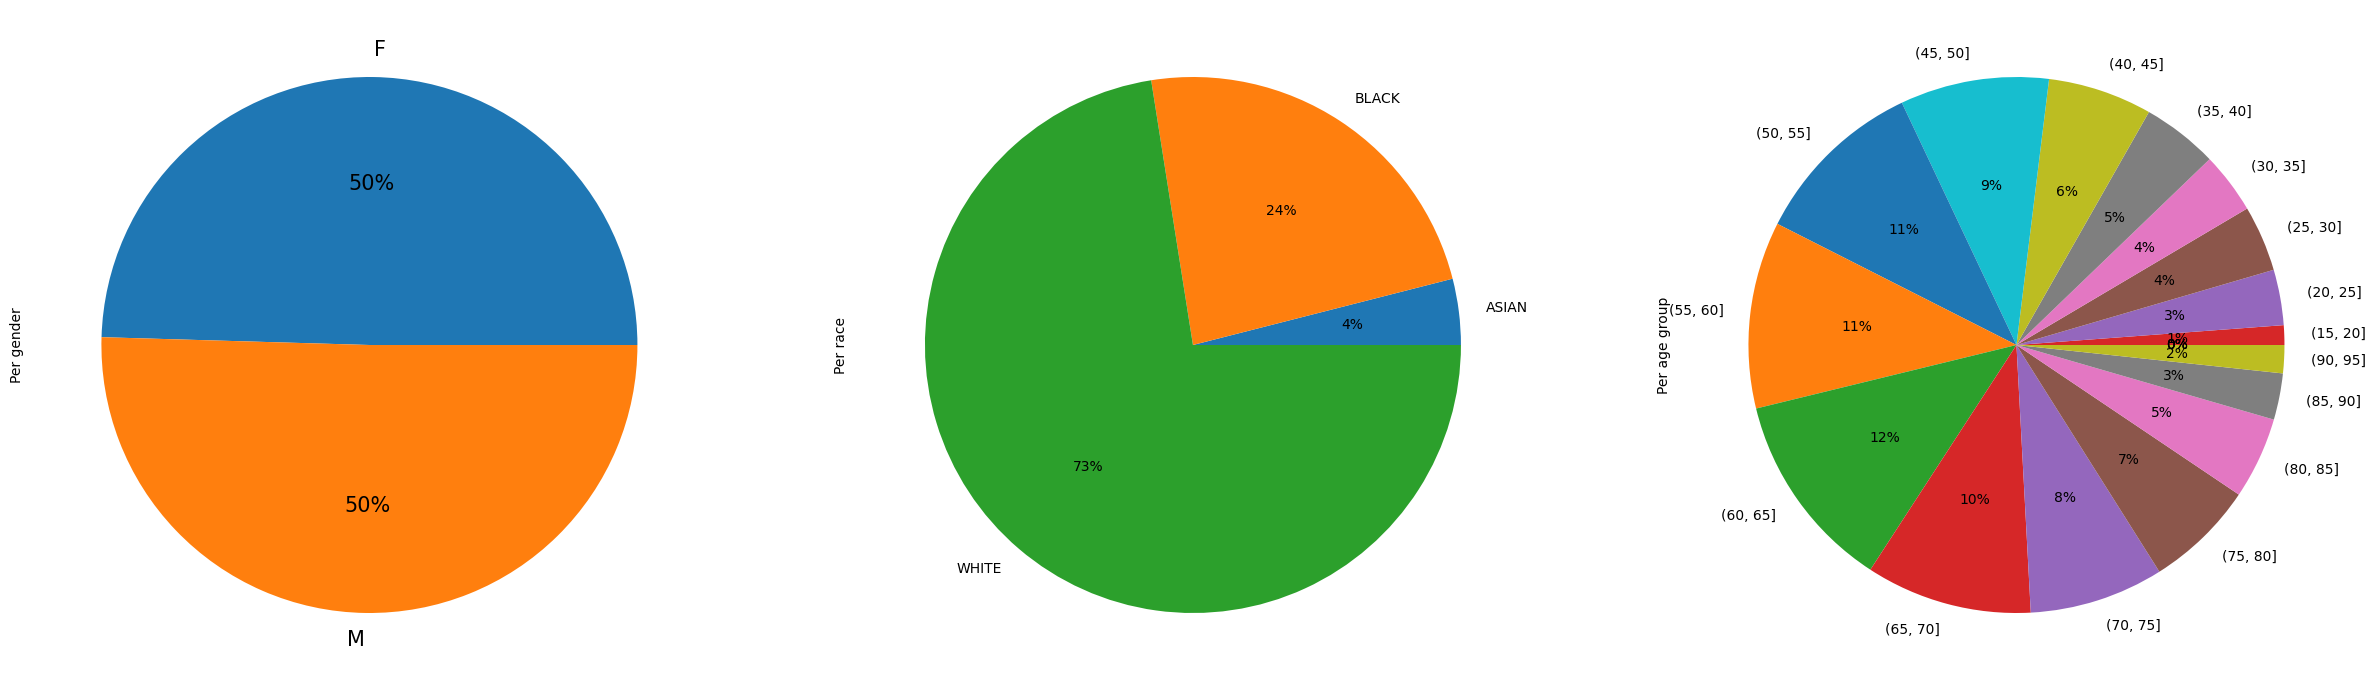

In [39]:
show_pie_chart(df_train)

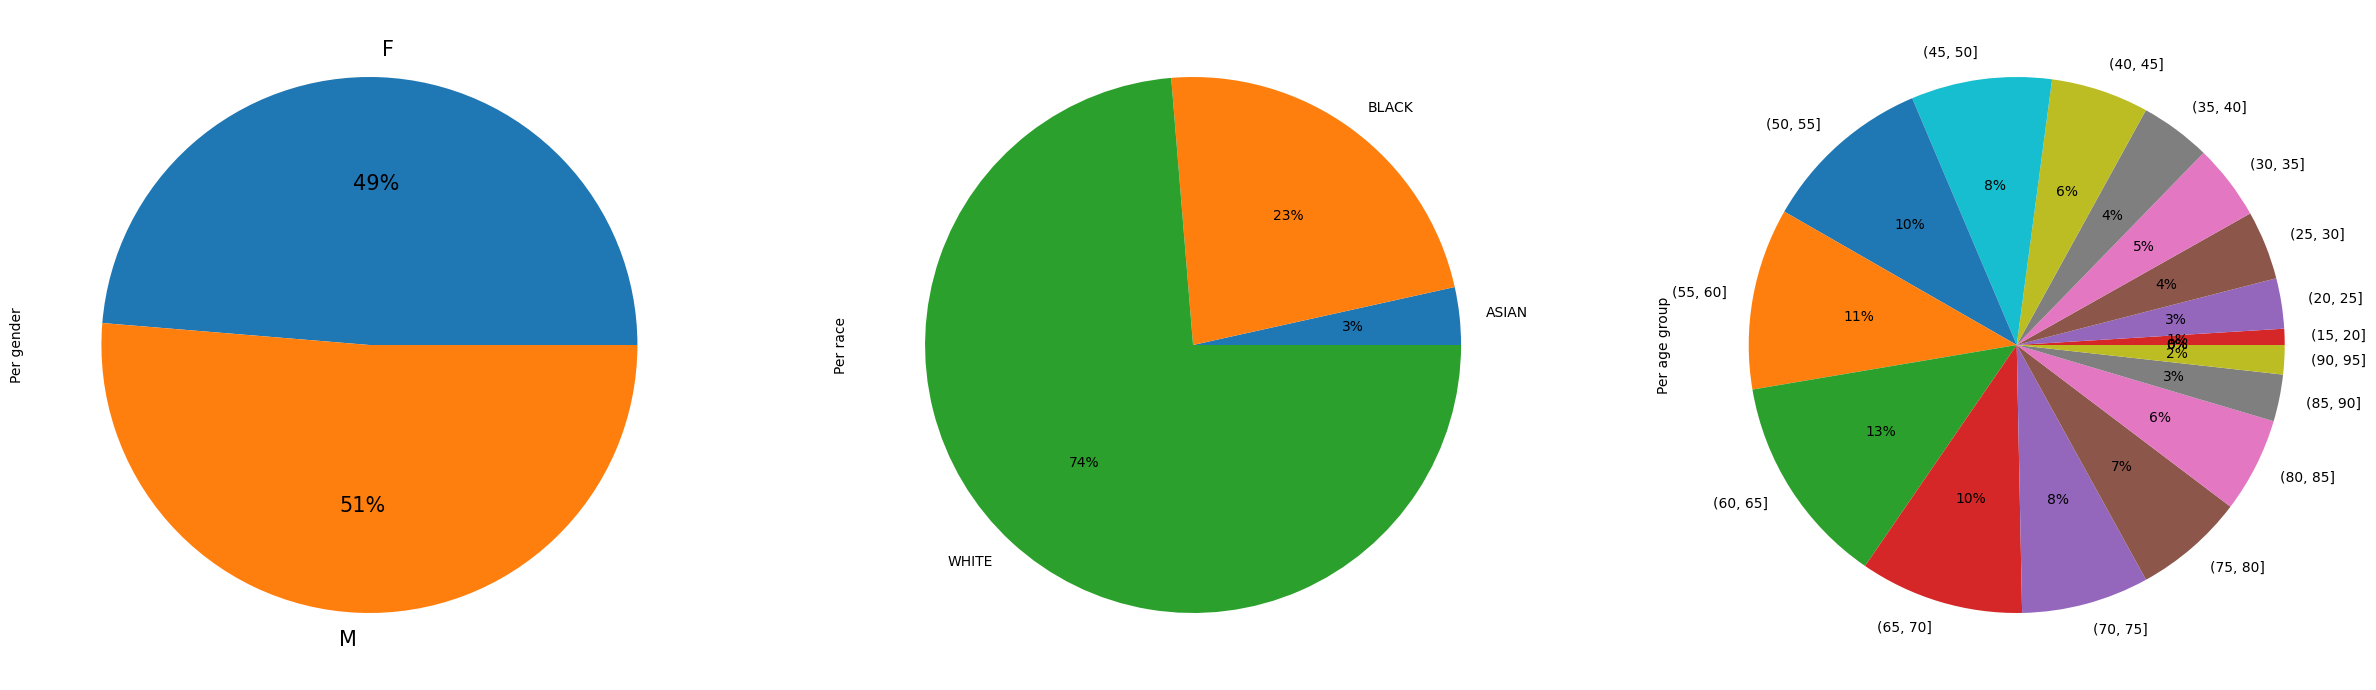

In [19]:
show_pie_chart(df_test)

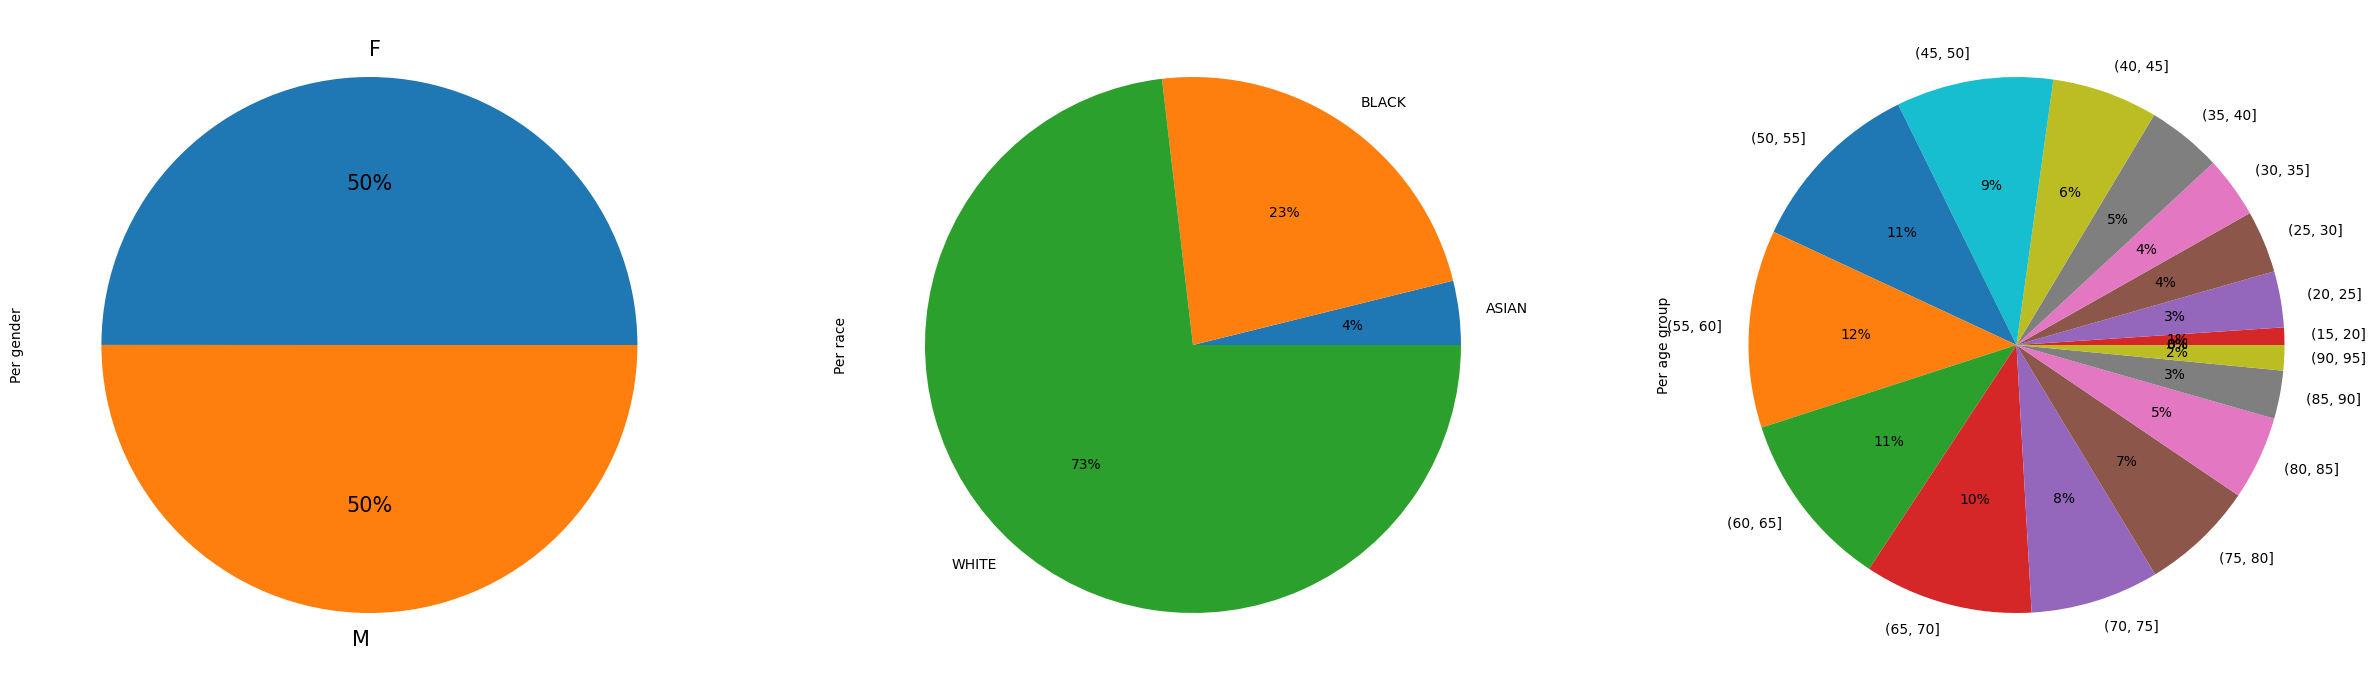

In [20]:
show_pie_chart(df_val)

# Race model

In [68]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [81]:
data_df = df_race
data_df.insert(5, "split","none", True)
unique_id = data_df.img_index.unique() #data_df.subject_id.unique()

train_percent, valid_percent, test_percent = 0.60, 0.10, 0.30

unique_id = shuffle(unique_id)
value1 = (round(len(unique_id)*train_percent))
value2 = (round(len(unique_id)*valid_percent))
value3 = value1 + value2
value4 = (round(len(unique_id)*test_percent))

print("Images in training set: " + str(value1))
print("Images in validation set: " + str(value2))
print("Images in testing set: " + str(value4))

train_sub_id = unique_id[:value1]
validate_sub_id = unique_id[value1:value3]
test_sub_id = unique_id[value3:]
print(len(train_sub_id), len(validate_sub_id))
train_sub_id[:10]

In [85]:
data_df.dataset.value_counts()

train    34800
test     18083
val       6105
Name: dataset, dtype: int64

In [ ]:
X_train

In [70]:
X_race = X_all[df_race['img_index']]
y = df_race['race']

In [72]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X_race, y, test_size= 1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(X_train.shape, X_test.shape, X_val.shape)

MemoryError: Unable to allocate 8.10 GiB for an array with shape (44241, 256, 256, 3) and data type uint8